In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to your CSV file in Google Drive
csv_file_path = "/content/drive/MyDrive/BBM409_datasets/insurance.csv"

# Read the CSV file using pandas
df = pd.read_csv(csv_file_path)

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# MIN-MAX NORMALIZATION
def min_max_normalization(df, columns_to_normalize):
    for column in columns_to_normalize:
        min_val = df[column].min()
        max_val = df[column].max()

        if min_val == max_val:
            df[column] = 0  # Avoid division by zero
        else:
            df[column] = (df[column] - min_val) / (max_val - min_val)

In [ ]:
#Euclidean Distance
def get_euclidian_distance(p1,p2):
    dist = np.sqrt(np.sum((p1-p2)**2))
    return dist

In [ ]:
# Manhattan Distance
def get_manhattan_distance(point1, point2):
    return np.sum(np.abs(point1 - point2))

In [ ]:
# mae function
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Pre-Processing

In [ ]:
df_target = df['charges']
df_var = df.iloc[:, :-1]

In [ ]:
# min-max normalization of numeric data
min_max_normalization(df_var, ['age', 'bmi', 'children'])

print(df_var.head(10))

        age     sex       bmi  children smoker     region
0  0.021739  female  0.321227       0.0    yes  southwest
1  0.000000    male  0.479150       0.2     no  southeast
2  0.217391    male  0.458434       0.6     no  southeast
3  0.326087    male  0.181464       0.0     no  northwest
4  0.304348    male  0.347592       0.0     no  northwest
5  0.282609  female  0.263115       0.0     no  southeast
6  0.608696  female  0.470272       0.2     no  southeast
7  0.413043  female  0.316922       0.6     no  northwest
8  0.413043    male  0.373150       0.4     no  northeast
9  0.913043  female  0.265806       0.0     no  northwest


In [ ]:
# one-hot encoding sex, region and smoker
# they will be one-hot encoded, because there is no hierarchical relationship between them
df_var = pd.get_dummies(df_var, columns=['sex'], prefix=['sex'])
df_var = pd.get_dummies(df_var, columns=['smoker'], prefix=['smoker'])
df_var = pd.get_dummies(df_var, columns=['region'], prefix=['region'])

In [ ]:
df_ = pd.concat([df_var, df_target], axis=1)

In [ ]:
df_.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges
0,0.021739,0.321227,0.0,1,0,0,1,0,0,0,1,16884.92400
1,0.000000,0.479150,0.2,0,1,1,0,0,0,1,0,1725.55230
2,0.217391,0.458434,0.6,0,1,1,0,0,0,1,0,4449.46200
3,0.326087,0.181464,0.0,0,1,1,0,0,1,0,0,21984.47061
4,0.304348,0.347592,0.0,0,1,1,0,0,1,0,0,3866.85520


# KNN

In [ ]:
def KNN(X_train, X_test, y_train, k_val):
    predictions = []

    for test_data in X_test:
        distances = []
        for train_data in X_train:
            distances.append(get_euclidian_distance(train_data, test_data))

        k_neighbors_indices = np.argsort(distances)[:k_val]
        k_neighbor_labels = y_train[k_neighbors_indices]

        # Find the most common label among the k neighbors
        most_common_label = Counter(k_neighbor_labels).most_common(1)[0][0]

        predictions.append(most_common_label)

    return np.array(predictions)

In [ ]:
data = df_.values

# split data into features (X) and target (y)
X = data[:, :-1]
y = data[:, -1]

num_folds = 5

mae_values = []
mae_dict= {}

fold_size = len(X) // num_folds

# k-NN with different values of k for each fold
k_values = [1, 3, 5, 7, 9]
for k in k_values:
    k_mae_values = []
    for i in range(num_folds):
        # split the data into training and validation sets for this fold
        start = i * fold_size
        end = (i + 1) * fold_size
        X_val = X[start:end]
        y_val = y[start:end]
        X_train = np.concatenate((X[:start], X[end:]))
        y_train = np.concatenate((y[:start], y[end:]))

        y_pred = KNN(X_train, X_val, y_train, k)
        mae = calculate_mae(y_val, y_pred)
        mae_values.append(mae)
        k_mae_values.append(mae)
        print(f"mae in fold {i+1} of k-value {k} : {mae}")

    #calculate the average MAE of the current fold
    mean_mae = np.mean(k_mae_values)
    mae_dict[k] = mean_mae

# calculate the average MAE across all folds and k values
average_mae = np.mean(mae_values)
print(f'Average MAE: {average_mae:.2f}')

mae in fold 1 of k-value 1 : 3709.6581617191014
mae in fold 2 of k-value 1 : 3739.527503861423
mae in fold 3 of k-value 1 : 3406.6773594382025
mae in fold 4 of k-value 1 : 3557.7315422846445
mae in fold 5 of k-value 1 : 3324.428758460674
mae in fold 1 of k-value 3 : 3709.6581617191014
mae in fold 2 of k-value 3 : 3739.5018182808985
mae in fold 3 of k-value 3 : 3406.6773594382025
mae in fold 4 of k-value 3 : 3557.7315422846445
mae in fold 5 of k-value 3 : 3324.91553205618
mae in fold 1 of k-value 5 : 3709.6581617191014
mae in fold 2 of k-value 5 : 3738.502585509363
mae in fold 3 of k-value 5 : 3406.6773594382025
mae in fold 4 of k-value 5 : 3557.7315422846445
mae in fold 5 of k-value 5 : 3324.91553205618
mae in fold 1 of k-value 7 : 3709.6581617191014
mae in fold 2 of k-value 7 : 3738.502585509363
mae in fold 3 of k-value 7 : 3406.6773594382025
mae in fold 4 of k-value 7 : 3557.7315422846445
mae in fold 5 of k-value 7 : 3324.91553205618
mae in fold 1 of k-value 9 : 3709.6581617191014
ma

# Weighted kNN

In [ ]:
def weighted_KNN(X_train, X_test, y_train, k_val):
    predictions = []

    for test_data in X_test:
        distances = []
        for train_data in X_train:
            distances.append(get_euclidian_distance(train_data, test_data))

        k_neighbors_indices = np.argsort(distances)[:k_val]
        k_neighbor_labels = y_train[k_neighbors_indices]
        k_neighbor_distances = np.array(distances)[k_neighbors_indices]

        weights = 1 / (k_neighbor_distances + 1e-6)  # Adding a small value to avoid division by zero

        weighted_sum = np.sum(weights * k_neighbor_labels)

        weighted_prediction = int(round(weighted_sum / np.sum(weights)))

        predictions.append(weighted_prediction)

    return predictions


In [ ]:
data = df_.values

# split data into features (X) and target (y)
X = data[:, :-1]
y = data[:, -1]

num_folds = 5

mae_values_weighted = []
mae_dict_weightes = {}

fold_size = len(X) // num_folds

# k-NN with different values of k for each fold
k_values = [1, 3, 5, 7 ,9]
for k in k_values:
    k_mae_values = []
    for i in range(num_folds):
        # split the data into training and validation sets for this fold
        start = i * fold_size
        end = (i + 1) * fold_size
        X_val = X[start:end]
        y_val = y[start:end]
        X_train = np.concatenate((X[:start], X[end:]))
        y_train = np.concatenate((y[:start], y[end:]))

        y_pred = weighted_KNN(X_train, X_val, y_train,  k)
        mae = calculate_mae(y_val, y_pred)
        mae_values_weighted.append(mae)
        k_mae_values.append(mae)
        print(f"mae in fold {i+1} of k-value {k} : {mae}")

    # calculate the average MAE across all folds and k values
    mean_mae = np.mean(k_mae_values)
    mae_dict_weightes[k] = mean_mae

# calculate the average MAE across all folds and k values
average_mae_weighted = np.mean(mae_values_weighted)
print(f'Average MAE: {average_mae_weighted:.2f}')

mae in fold 1 of k-value 1 : 3709.6640189138575
mae in fold 2 of k-value 1 : 3739.504094573034
mae in fold 3 of k-value 1 : 3406.696021273408
mae in fold 4 of k-value 1 : 3557.741173632959
mae in fold 5 of k-value 1 : 3324.4264735580527
mae in fold 1 of k-value 3 : 3522.265212921348
mae in fold 2 of k-value 3 : 3495.965183636704
mae in fold 3 of k-value 3 : 3026.49919835206
mae in fold 4 of k-value 3 : 3475.834226367041
mae in fold 5 of k-value 3 : 3456.8460694382024
mae in fold 1 of k-value 5 : 3556.0623488764045
mae in fold 2 of k-value 5 : 3497.744671794008
mae in fold 3 of k-value 5 : 3091.8399186516854
mae in fold 4 of k-value 5 : 3530.816770187266
mae in fold 5 of k-value 5 : 3493.1153713108615
mae in fold 1 of k-value 7 : 3656.3914691011237
mae in fold 2 of k-value 7 : 3564.0816448277155
mae in fold 3 of k-value 7 : 3250.6576343820225
mae in fold 4 of k-value 7 : 3462.762308764045
mae in fold 5 of k-value 7 : 3532.777476179775
mae in fold 1 of k-value 9 : 3732.6683968164793
mae 

#Error Analysis for Regression

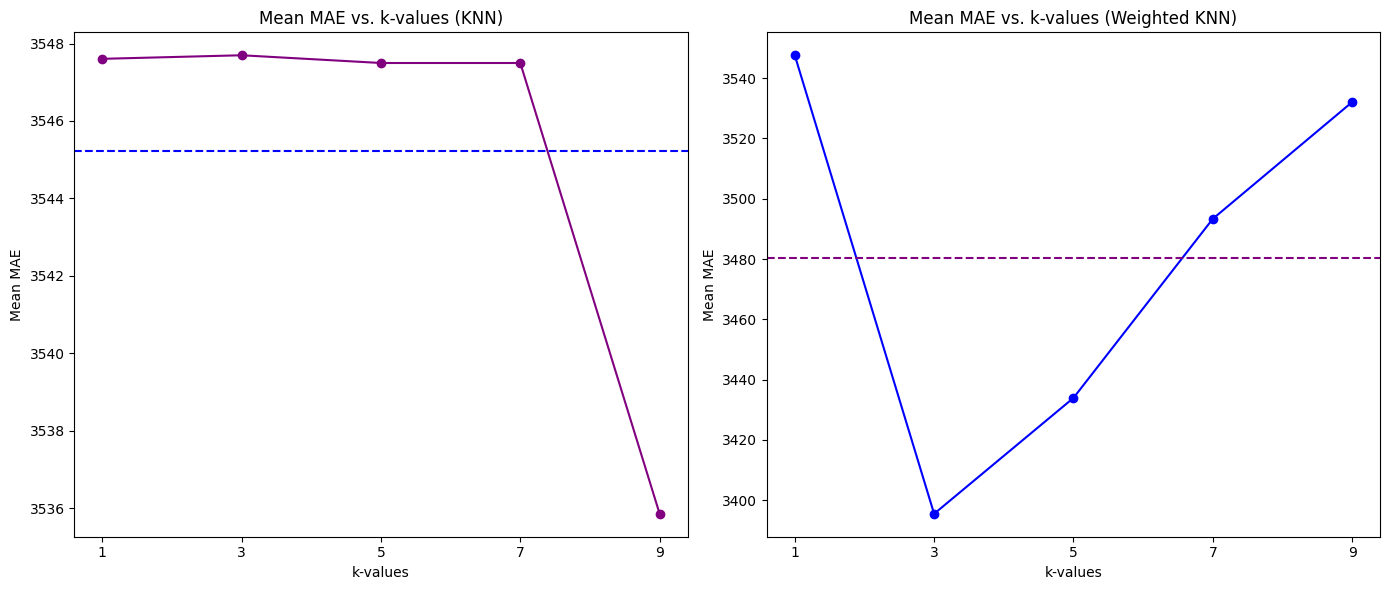

In [ ]:
k_values_1 = list(mae_dict.keys())
mean_mae_values_1 = list(mae_dict.values())
k_values_2 = list(mae_dict_weightes.keys())
mean_mae_values_2 = list(mae_dict_weightes.values())

# average MAE for each dictionary
average_mae_knn = np.mean(mean_mae_values_1)
average_mae_weighted_knn = np.mean(mean_mae_values_2)

plt.figure(figsize=(14, 6))

# subplot for mae_dict
plt.subplot(1, 2, 1)
plt.plot(k_values_1, mean_mae_values_1,marker='o', color='purple', label='Individual MAE')
plt.axhline(average_mae_knn, color='blue', linestyle='--', label='Average MAE')
plt.xlabel('k-values')
plt.ylabel('Mean MAE')
plt.title('Mean MAE vs. k-values (KNN)')
plt.xticks(k_values_1)

# subplot for mae_dict_weightes
plt.subplot(1, 2, 2)
plt.plot(k_values_2, mean_mae_values_2,marker='o', color='blue', label='Individual MAE')
plt.axhline(average_mae_weighted_knn, color='purple', linestyle='--', label='Average MAE')
plt.xlabel('k-values')
plt.ylabel('Mean MAE')
plt.title('Mean MAE vs. k-values (Weighted KNN)')
plt.xticks(k_values_2)

plt.tight_layout()
plt.show()


*   For "KNN", across the different values of k, there is a consistent MAE value with a slight difference in k value 9. this shows that, choice of k value doesn't have a significant impact on the MAE.

*   For "Weighted KNN", thw MAE values differantiate across the varios k values. The best MAE is in k=3. For the rest of the values, as k increase, error value increases, too.

*   Overall results are as follows;
    1. KNN Average MAE: 3545.23
    2. Weighted KNN Average MAE: 3480.48

*   Weighted KNN has a better performance in terms of average MAE values.

Weighted KNN has better performance than KNN due to its ability to assign variable weights to neighbour points, capturing local patterns. The coice of 'k' can influence the results.



